In [438]:
import pandas as pd
import numpy as np
import sys, os, json, time, collections, pickle
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

import scipy

%matplotlib inline


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

# fig.savefig("test.pdf",dpi=300)
plt.show()

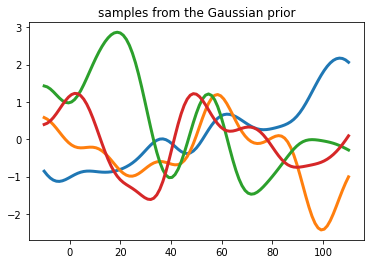

In [481]:
import numpy as np
import matplotlib.pyplot as plt 
from math import pi 
from scipy.spatial.distance import cdist
import scipy.stats as sts

x_prior = np.linspace(-10,110,101)
x_prior = x_prior.reshape(-1,1)
mu = np.zeros(x_prior.shape)

#defining the Kernel for the covariance function

def sec(a,b, length_scale , sigma) : 
    K = sigma * np.exp(-1/(2*length_scale) * cdist(a,b)**2)
    return K 

#defining the Gaussian Process prior

def GP(a , b, mu , kernel , length_scale, sigma , samples ) :
    f = np.random.multivariate_normal(mu.flatten(), kernel(a ,b , length_scale , sigma ) , samples)
    return f

prior = GP(x_prior ,x_prior, mu , sec , 100, 1 , 4)

fig=plt.figure()
# plt.grid()
plt.title('samples from the Gaussian prior')
plt.plot(x_prior , prior.T,lw=3)
fig.savefig("gaussian_prior.pdf",dpi=300)
plt.show()

In [51]:
out_path = '../data'
dataset_name = 'THA_topic'
raw_data_name = 'raw_w7h7'


file_list = glob.glob('{}/{}/{}/*.pkl'.format(out_path, dataset_name, raw_data_name))

plot_path = '{}/{}/{}/plot'.format(out_path, dataset_name, raw_data_name)
os.makedirs(plot_path, exist_ok=True)

In [70]:
effect_dict = {}
for file in file_list:
    file_name = file.split('/')[-1]
    topic_id = file_name.split('.')[0].split('_')[-1]
    with open('{}/{}/{}/topic_{}.pkl'.format(out_path, dataset_name, raw_data_name, topic_id),'rb') as f:
        dataset = pickle.load(f)
    treatment = dataset['treatment']
    treatment = treatment
    treatment = np.where(treatment > 0, 1, 0)
    covariate = dataset['covariate']
    covariate = np.concatenate([v.toarray() for v in covariate],0) 

    outcome = dataset['outcome'][:,:,].sum(1) # number of events; sum of all days
    # not binary vector
    outcome_sep_day = dataset['outcome'][:,:,] # number of events; sum of all days
    print('topic {} data loaded'.format(topic_id))
    print('outcome',outcome.shape, 'outcome_sep_day',outcome_sep_day.shape)
    continue
    scaler = StandardScaler()
    X = scaler.fit_transform(covariate)
    # print(X.shape)

    cls = LogisticRegression(random_state=42,max_iter=20)
    cls = CalibratedClassifierCV(cls)
    cls.fit(X, treatment)
    print('propensity scoring model trained')

    propensity = cls.predict_proba(covariate)
    propensity = propensity[:,1]

    # caliper = propensity.std()*0.2
    propensity_logit = scipy.special.logit(propensity)
    caliper = propensity_logit.std()* 0.2

    # get pairs and calculate average treatment effect 
    # for each treatment ele, find a control, most similar
    controlled_indices = np.where(treatment == 0)[0]
    treatment_idices = treatment.nonzero()[0]
    np.random.shuffle(treatment_idices)
    # treatment_idices

    eff_list = []
    all_outcome_treatment = []
    all_control_outcome = []
    all_control_outcome_day = []
    all_treatment_outcome_day = []
    used_control_indices = []
    n_pairs = 0
    for i in treatment_idices:
        curr = propensity_logit[controlled_indices]
        diff = np.abs(curr-propensity_logit[i])
        min_idx = np.argmin(diff, axis=0)
        min_diff = diff[min_idx]
        if min_diff < caliper:
            # get treatment effect?
            outcome_control = outcome[controlled_indices[min_idx]]
            outcome_treatment = outcome[i]
            # print('outcome_control',outcome_control,'outcome_treatment',outcome_treatment)
            eff = outcome_treatment-outcome_control

            eff_list.append(eff)
            all_outcome_treatment.append(outcome_treatment)
            all_control_outcome.append(outcome_control)
            all_control_outcome_day.append(outcome_sep_day[controlled_indices[min_idx]])
            all_treatment_outcome_day.append(outcome_sep_day[i])
            n_pairs += 1
            used_control_indices.append(controlled_indices[min_idx])
        else:
            print('min diff is larger than the caliper {:.5f}; skip'.format(caliper))

    eff_list = np.stack(eff_list,0)
    all_control_outcome = np.stack(all_control_outcome,0)
    all_outcome_treatment = np.stack(all_outcome_treatment,0)
    all_control_outcome_day = np.stack(all_control_outcome_day,0)
    all_treatment_outcome_day = np.stack(all_treatment_outcome_day,0)

    all_control_outcome_max = all_control_outcome.max(0)
    all_outcome_treatment_max = all_outcome_treatment.max(0)
    all_control_outcome_day_max = all_control_outcome_day.max(0)
    all_treatment_outcome_day_max = all_treatment_outcome_day.max(0)

    print('eff_list',eff_list.shape)
    effect_dict[int(topic_id)] = eff_list.mean(0)
#     break


# with open('{}/{}/{}/plot/effect_dict.pkl'.format(out_path, dataset_name, raw_data_name),'wb') as f:
#     pickle.dump(effect_dict,f)

topic 22 data loaded
outcome (3372, 20) outcome_sep_day (3372, 7, 20)
topic 46 data loaded
outcome (4095, 20) outcome_sep_day (4095, 7, 20)
topic 42 data loaded
outcome (3380, 20) outcome_sep_day (3380, 7, 20)
topic 29 data loaded
outcome (4225, 20) outcome_sep_day (4225, 7, 20)
topic 19 data loaded
outcome (3175, 20) outcome_sep_day (3175, 7, 20)
topic 20 data loaded
outcome (3303, 20) outcome_sep_day (3303, 7, 20)
topic 36 data loaded
outcome (4431, 20) outcome_sep_day (4431, 7, 20)
topic 48 data loaded
outcome (3133, 20) outcome_sep_day (3133, 7, 20)
topic 3 data loaded
outcome (3301, 20) outcome_sep_day (3301, 7, 20)
topic 31 data loaded
outcome (3682, 20) outcome_sep_day (3682, 7, 20)
topic 39 data loaded
outcome (4996, 20) outcome_sep_day (4996, 7, 20)
topic 35 data loaded
outcome (4224, 20) outcome_sep_day (4224, 7, 20)
topic 11 data loaded
outcome (2516, 20) outcome_sep_day (2516, 7, 20)
topic 32 data loaded
outcome (3871, 20) outcome_sep_day (3871, 7, 20)
topic 7 data loaded
o

In [75]:
ATE = eff_list.mean(0)
print(ATE)
scipy.stats.zscore(ATE)
# effect_dict.keys()
# with open('{}/{}/{}/plot/effect_dict.pkl'.format(out_path, dataset_name, raw_data_name),'wb') as f:
#     pickle.dump(effect_dict,f)

[ 0.38541667  0.12083333  0.14166667  0.36666667  0.06458333  0.02708333
  0.05        0.00833333  0.0375      0.03125     0.0875      0.00208333
 -0.00208333 -0.02083333  0.03958333  0.00625     0.17708333  0.2625
  0.18958333  0.        ]


array([ 2.42973816,  0.1871746 ,  0.3637544 ,  2.27081633, -0.28959089,
       -0.60743454, -0.41319675, -0.76635637, -0.51914464, -0.57211858,
       -0.0953531 , -0.81933031, -0.85464627, -1.0135681 , -0.50148666,
       -0.78401435,  0.66394008,  1.38791729,  0.76988796, -0.83698829])

In [168]:
with open('{}/{}/{}/plot/effect_dict.pkl'.format(out_path, dataset_name, raw_data_name),'rb') as f:
    effect_dict = pickle.load(f)

In [172]:
# effect_dict.keys()
res = []
for i in range(40):
    tmp = effect_dict[i]
    res.append(tmp)
#     print(len(tmp))


In [173]:
res = np.stack(res)

In [175]:
import csv
from scipy import stats

# res
labels = ['statement', 'appeal','express cooperate','consult','diplomatic cooperation','material cooperation','provide aid','yield','investigate','demand','disapprove','reject','threaten','protest','minitary','reduce relation','coerce','assault','fight','mass violence']

f = open('{}/{}/{}/plot/significance.csv'.format(out_path, dataset_name, raw_data_name),'a')
wrt = csv.writer(f)
wrt.writerow(["event-idx", "event-type", 'rank', "topic-id","p-value"])
# with open('{}/{}/{}/plot/significance.csv'.format(out_path, dataset_name, raw_data_name), 'w', newline='') as outcsv:
#     writer = csv.writer(outcsv)
#     writer.writerow(["event-idx", "event-type", 'rank', "topic-id","p-value"])
z_list = []
for j in range(20):
    z_list.append(stats.zscore(res[:,j]))
    z_scores = stats.zscore(res[:,j])
    p_values = scipy.stats.norm.sf(abs(z_scores))*2
    sorted_idx = np.argsort(p_values)
    sig_idx = np.where(p_values<0.05,1,0)
    len_nonzero = len(np.nonzero(sig_idx)[0])
    topic_idx = sorted_idx[:len_nonzero]
    top_p = p_values[topic_idx]
    print(labels[j],len_nonzero,top_p,topic_idx)
    for i in range(len(topic_idx)):
        r = [j,labels[j],i,topic_idx[i],top_p[i]]
        print(r)
        wrt.writerow(r)
f.close()

statement 3 [0.0001935  0.00337651 0.01618175] [39 12 36]
[0, 'statement', 0, 39, 0.0001935010260341716]
[0, 'statement', 1, 12, 0.0033765148317463282]
[0, 'statement', 2, 36, 0.016181745549221128]
appeal 2 [1.75103212e-06 3.16909068e-02] [39 12]
[1, 'appeal', 0, 39, 1.7510321238764244e-06]
[1, 'appeal', 1, 12, 0.031690906777826405]
express cooperate 3 [0.00086289 0.00573545 0.04421408] [39 12 36]
[2, 'express cooperate', 0, 39, 0.0008628887380709298]
[2, 'express cooperate', 1, 12, 0.005735445949973009]
[2, 'express cooperate', 2, 36, 0.04421407966667518]
consult 3 [0.00077572 0.03152055 0.03302116] [39 38 36]
[3, 'consult', 0, 39, 0.0007757153473597674]
[3, 'consult', 1, 38, 0.03152054797942534]
[3, 'consult', 2, 36, 0.033021159755334595]
diplomatic cooperation 4 [4.28009665e-05 2.83184849e-02 4.04171489e-02 4.70758531e-02] [39 12 36 23]
[4, 'diplomatic cooperation', 0, 39, 4.280096651244732e-05]
[4, 'diplomatic cooperation', 1, 12, 0.02831848488030284]
[4, 'diplomatic cooperation', 

In [407]:
tmp_file = '{}/{}/{}/plot/significance.csv'.format(out_path, dataset_name, raw_data_name)
df=pd.read_csv(tmp_file,sep=',')
df.head()

,event-idx,event-type,rank,topic-id,p-value
0,0,statement,0,39,0.000194
1,0,statement,1,12,0.003377
2,0,statement,2,36,0.016182
3,1,appeal,0,39,0.000002
4,1,appeal,1,12,0.031691


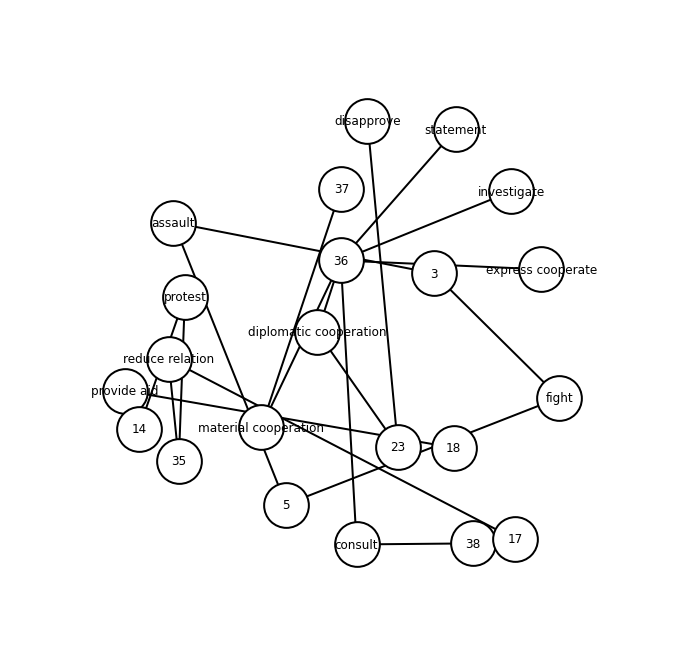

In [227]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

B = nx.Graph()
# B.add_nodes_from(df['topic-id'].unique(), bipartite=0)
# B.add_nodes_from(df['event-type'].unique(), bipartite=1)
for i,row in df.iterrows():
    if row['topic-id'] in [12,39]:
        continue
    B.add_edge(row['topic-id'], row['event-type'])
#     if i>10:
#         break
# print(nx.is_connected(B))

# top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
# bottom_nodes = set(B) - top_nodes
# print(round(bipartite.density(B, bottom_nodes), 2))

# G = bipartite.projected_graph(B, top_nodes)
# RB = bipartite.random_graph(5, 7, 0.2)
# RB_top = {n for n, d in RB.nodes(data=True) if d["bipartite"] == 0}
# RB_bottom = set(RB) - RB_top
# print(list(RB_top))

# print(list(RB_bottom))
# top = nx.bipartite.sets(B)[0]
# pos = nx.bipartite_layout(B, top)
# nx.draw(B, pos=pos, with_labels=True, node_color=['green','green','green','green','blue','blue','blue'])
# plt.show()
# G.add_edge(1, 2)
# G.add_edge(1, 3)
# G.add_edge(1, 5)
# G.add_edge(2, 3)
# G.add_edge(3, 4)
# G.add_edge(4, 5)

# explicitly set positions
# pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), 5: (5, 0.03)}
pos = nx.spring_layout(B,k=0.8, iterations=20)#, seed=42)  # Seed layout for reproducibility
plt.figure(1,figsize=(12,12)) 

options = {
    "font_size": 12,
    "node_size": 2000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}
nx.draw_networkx(B, pos, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)

plt.axis("off")
plt.show()

# Separate by group
# l, r = nx.bipartite.sets(B)
# pos = {}

# # Update position for node from each group
# pos.update((node, (1, index)) for index, node in enumerate(l))
# pos.update((node, (2, index)) for index, node in enumerate(r))
# pos = nx.bipartite_layout(B, RB_bottom)

# nx.draw(B, pos=pos)
# plt.show()

In [115]:
z_scores = z_list[0]
print(z_scores)
p_values = scipy.stats.norm.sf(abs(z_scores))*2 #twosided

for i,v in enumerate(p_values):
    if v < 0.05:
        print(i,v)


[-0.5328091   0.61472828 -0.12262481  0.35190721 -0.58916714  0.53363787
 -0.38744909 -0.09260623 -0.00980502 -0.72705574  0.00522777 -0.34534109
  2.93120353 -0.86905439 -0.71566017 -0.12038314 -0.69053147  1.25444892
 -0.4255117  -0.29704554 -0.39773962 -0.09970198 -0.34321247 -1.91868015
 -0.31933902 -0.24407894 -0.15441619 -0.22957382 -0.37053781  0.41162807
 -0.20587474 -0.76600198  0.18349516 -0.47536475 -0.37768447 -0.51194009
  2.40479036 -0.24234155  0.16311159  3.72735343]
12 0.0033765148317463282
36 0.016181745549221128
39 0.0001935010260341716


['water,flood', 'border,migrant,refugee,detained,junta', 'right,human,trafficking,abuse,\nwomen,child,government,war,\njustice,crime,authority', 'Cambodia,troop, border,curfew,\nterritory,soldier,disputed,foreign', 'summit,foreign,talk,\npresident,meeting,country', 'china,railway,train', 'court,charge,legal,judge,\nlawyer,accused,criminal', 'government,shutdown,foreign,\npress,statement,affair,issue,\nnews,journalist,letter', 'education', 'police,suspect,arrested,seized', 'province,district,flood,local,resident', 'decree,emergency,law,ban,lift,\nwildlife,animal,elephant,robber']
{'water,flood': (0.6, -12), 'border,migrant,refugee,detained,junta': (0.4, -8), 'right,human,trafficking,abuse,\nwomen,child,government,war,\njustice,crime,authority': (0.3, -4), 'Cambodia,troop, border,curfew,\nterritory,soldier,disputed,foreign': (0.3, 2), 'summit,foreign,talk,\npresident,meeting,country': (0.3, 8), 'china,railway,train': (0.3, 12), 'court,charge,legal,judge,\nlawyer,accused,criminal': (0.6, 

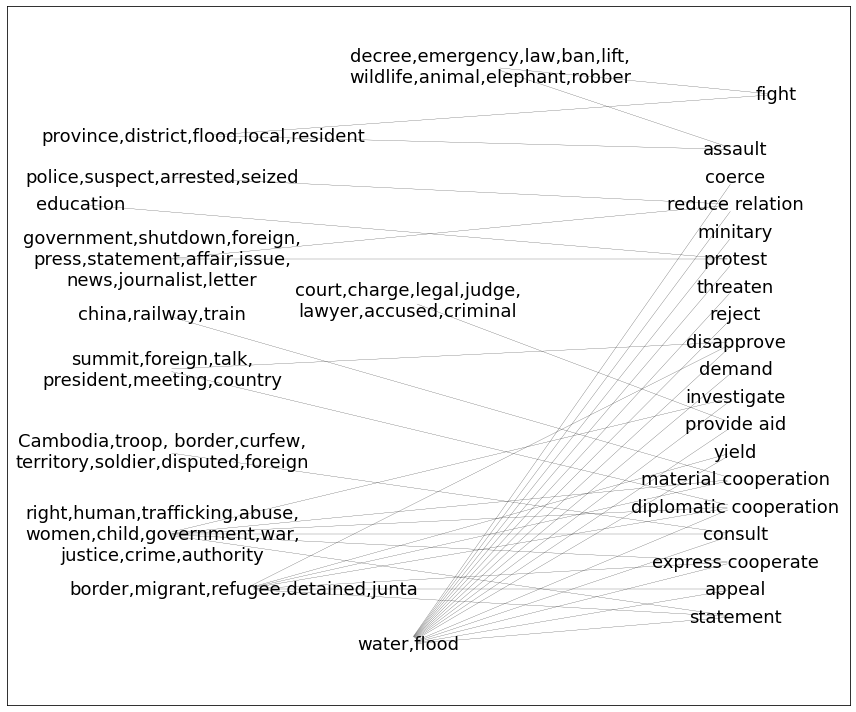

In [437]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import random
B = nx.Graph()
nodes = {0:list(df['topic-id'].unique()),1:list(df['event-type'].unique())}
topic_dict = {
    39:"water,flood",
    12:"border,migrant,refugee,detained,junta",
    36:"right,human,trafficking,abuse,\nwomen,child,government,war,\njustice,crime,authority",
    38:"Cambodia,troop, border,curfew,\nterritory,soldier,disputed,foreign",
    23:"summit,foreign,talk,\npresident,meeting,country",
    37:"china,railway,train",
    18:"court,charge,legal,judge,\nlawyer,accused,criminal",
    35:"government,shutdown,foreign,\npress,statement,affair,issue,\nnews,journalist,letter",
    14:"education",
    17:"police,suspect,arrested,seized",
    5:"province,district,flood,local,resident",
    3:"decree,emergency,law,ban,lift,\nwildlife,animal,elephant,robber"
}
nodes[2] = []
for v in nodes[0]:
#     print()
    nodes[2].append(topic_dict[v])
print(nodes[2])

# tmp = nodes[0]
nodes[0] = nodes[2]
# nodes[2] = nodes[0]
B.add_nodes_from(nodes[0], bipartite=0)
B.add_nodes_from(nodes[1], bipartite=1)
for i,row in df.iterrows():
#     if row['topic-id'] in [12,39]:
#         continue
#     print( row['event-type'])
    B.add_edge(topic_dict[row['topic-id']], row['event-type'])
# print(B.edges())
# k = 2
# n = 10
# ne = 15
# e = 19 # since you want total 685 edges, you can have ~229 edges in between two 
        # adjacent sets of nodes

# for i in range(k):
#     nodes[i] = list(range(n*i, n*(i+1)))

# for i in range(k):
#     B.add_nodes_from(nodes[i], bipartite=k)

# edges = []
# # for j in range(k-1):
# for i in range(e):
#     edges.append((random.choice(nodes[j]), random.choice(nodes[j+1])))

# B.add_edges_from(edges[:ne])
options = {
    "font_size": 18,
#     "node_size": 2000,
    "node_color": "white",
#     "edgecolors": "gray",
#     "linewidths": 2,
    "width": 0.2,
}
k = 2
pos = dict()
v = [1,3,4,6]
for j in range(k):
# for j in [2,1]:
#     print(nodes[j],'????')
    pos.update( (n, (j, i)) for i, n in enumerate(nodes[j]) )
    
pos['decree,emergency,law,ban,lift,\nwildlife,animal,elephant,robber'] = (0.7,30)
pos['province,district,flood,local,resident'] = (0.35,25)
pos['police,suspect,arrested,seized'] = (0.3,22)
pos['education'] = (0.2,20)
pos['government,shutdown,foreign,\npress,statement,affair,issue,\nnews,journalist,letter'] = (0.3,16)
pos['court,charge,legal,judge,\nlawyer,accused,criminal'] = (0.6,13)
pos['china,railway,train'] = (0.3,12)
pos['summit,foreign,talk,\npresident,meeting,country'] = (0.3,8)
pos['Cambodia,troop, border,curfew,\nterritory,soldier,disputed,foreign'] = (0.3,2)
pos['right,human,trafficking,abuse,\nwomen,child,government,war,\njustice,crime,authority'] = (0.3,-4)
pos['border,migrant,refugee,detained,junta'] = (0.4,-8)
pos['water,flood'] = (0.6,-12)
 
print(pos,'pos')
pos['fight'] = (1.05,28)
pos['assault'] = (1,24)
pos['coerce'] = (1,22)
pos['reduce relation'] = (1,20)
pos['minitary'] = (1,18)
pos['protest'] = (1,16)
pos['threaten'] = (1,14)
pos['reject'] = (1,12)
pos['disapprove'] = (1,10)
pos['demand'] = (1,8)
pos['investigate'] = (1,6)
pos['yield'] = (1,2)
pos['provide aid'] = (1,4)
pos['material cooperation'] = (1,0)
pos['diplomatic cooperation'] = (1,-2)
pos['consult'] = (1,-4)
pos['express cooperate'] = (1,-6)
pos['appeal'] = (1,-8)
pos['statement'] = (1,-10)

fig = plt.figure(figsize=(12,10))

nx.draw_networkx(B, pos=pos, **options)
plt.tight_layout()
# fig.tight_layout()
# plt.axis('off')
# plt.subplots_adjust(left=0.8, right=0.9, top=0.9, bottom=0.1)
fig.savefig('test.pdf')

plt.show() 


In [409]:
# j=0
# for i, n in enumerate(nodes):
#     print((n, (j, i)))
#     print('===')
# nodes
df

,event-idx,event-type,rank,topic-id,p-value
0,0,statement,0,39,1.935010e-04
1,0,statement,1,12,3.376515e-03
2,0,statement,2,36,1.618175e-02
3,1,appeal,0,39,1.751032e-06
4,1,appeal,1,12,3.169091e-02
5,2,express cooperate,0,39,8.628887e-04
6,2,express cooperate,1,12,5.735446e-03
7,2,express cooperate,2,36,4.421408e-02
8,3,consult,0,39,7.757153e-04
9,3,consult,1,38,3.152055e-02


In [129]:
# np.where(p_values<0.05,1,0)
np.nonzero(sig_idx)
sig_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [122]:
# np.where(p_values<0.1,1,0)
print(p_values)
np.argsort(p_values)

[5.94165733e-01 5.38734183e-01 9.02404206e-01 7.24907855e-01
 5.55749158e-01 5.93592099e-01 6.98423770e-01 9.26216397e-01
 9.92176852e-01 4.67191813e-01 9.95828864e-01 7.29837961e-01
 3.37651483e-03 3.84817381e-01 4.74201211e-01 9.04179650e-01
 4.89860029e-01 2.09678882e-01 6.70463697e-01 7.66431741e-01
 6.90822130e-01 9.20580926e-01 7.31438625e-01 5.50248253e-02
 7.49469450e-01 8.07169685e-01 8.77281589e-01 8.18422952e-01
 7.10981807e-01 6.80612054e-01 8.36888758e-01 4.43675123e-01
 8.54409519e-01 6.34527013e-01 7.05665007e-01 6.08692942e-01
 1.61817455e-02 8.08515525e-01 8.70430571e-01 1.93501026e-04]


array([39, 12, 36, 23, 17, 13, 31,  9, 14, 16,  1,  4,  5,  0, 35, 33, 18,
       29, 20,  6, 34, 28,  3, 11, 22, 24, 19, 25, 37, 27, 30, 32, 38, 26,
        2, 15, 21,  7,  8, 10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
20


/home/sdeng/anaconda2/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/sdeng/anaconda2/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


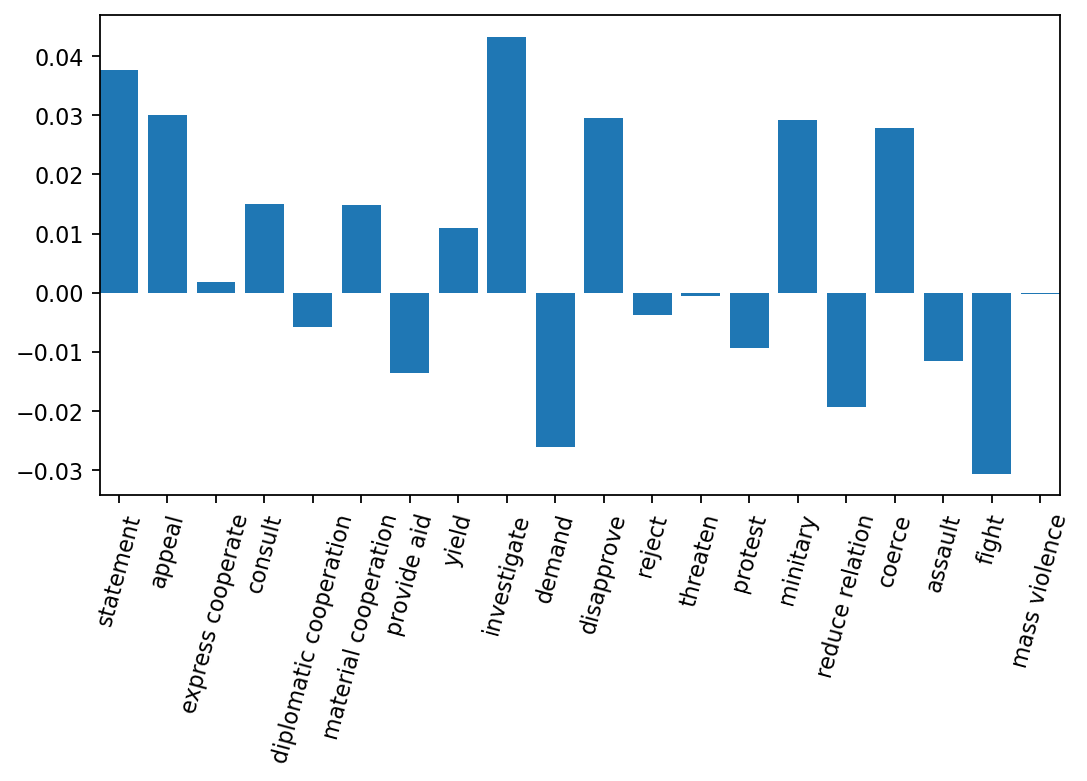

In [380]:

students = np.array([ 4.3154e-02,  2.7553e-02,  6.5416e-03, -1.4222e-02, -5.5938e-03,
         7.2900e-03,  2.7261e-03, -1.7121e-02,  1.0777e-02,  1.6881e-02,
         1.7513e-02,  1.7930e-02, -2.1634e-02, -3.5397e-03,  1.1621e-02,
        -1.7440e-02,  1.4912e-02, -3.3607e-02,  8.3051e-03, -5.0610e-22])
students = np.array([ 0.0377,  0.0300,  0.0019,  0.0150, -0.0058,  0.0148, -0.0135,  0.0110,
         0.0432, -0.0261,  0.0296, -0.0038, -0.0005, -0.0094,  0.0292, -0.0193,
         0.0278, -0.0115, -0.0306, -0.0002])
fig = plt.figure(figsize=(6,3),dpi=160)
ax = fig.add_axes([0,0,1,1])
langs = [i for i in range(20)]
print(langs)
# students = [23,17,35,29,12]
labels = ['statement', 'appeal','express cooperate','consult','diplomatic cooperation','material cooperation','provide aid','yield','investigate','demand','disapprove','reject','threaten','protest','minitary','reduce relation','coerce','assault','fight','mass violence']
# ax.set_xticks(x)
print(len(labels))
ax.bar(labels,students)
ax.set_xticklabels(labels)
ax.margins(x=0)
plt.xticks(rotation=75)
# ax.legend()
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
fig.tight_layout()
plt.show()
# print(students.shape,langs)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
20


/home/sdeng/anaconda2/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/sdeng/anaconda2/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


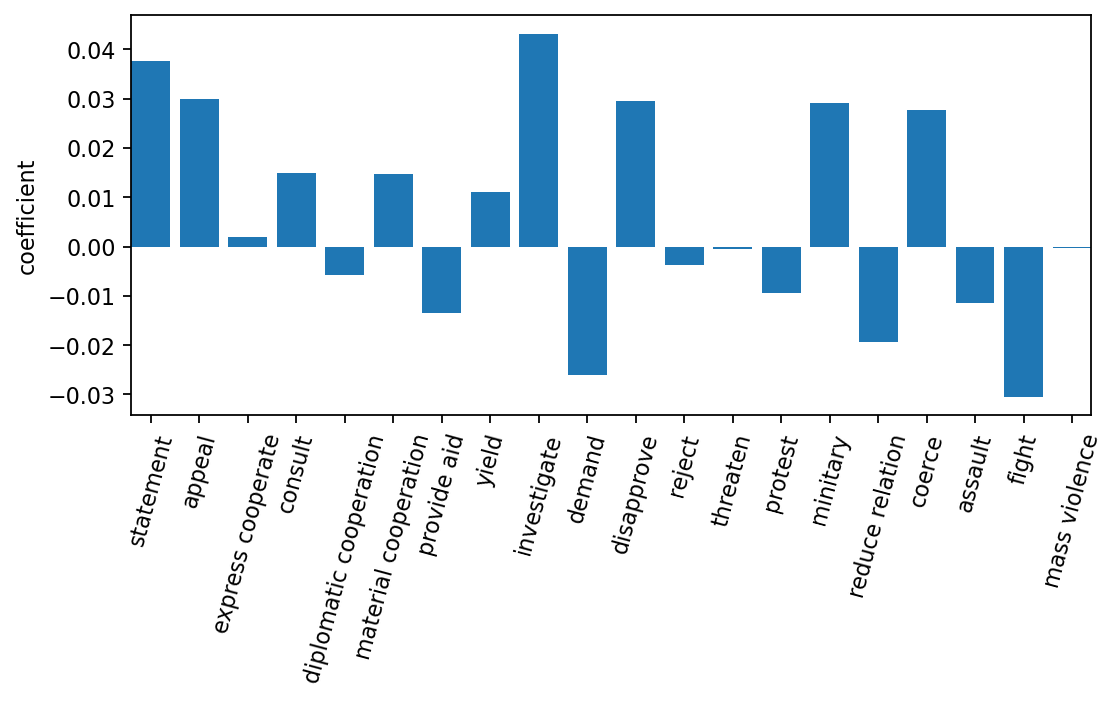

In [44]:

students = np.array([ 4.3154e-02,  2.7553e-02,  6.5416e-03, -1.4222e-02, -5.5938e-03,
         7.2900e-03,  2.7261e-03, -1.7121e-02,  1.0777e-02,  1.6881e-02,
         1.7513e-02,  1.7930e-02, -2.1634e-02, -3.5397e-03,  1.1621e-02,
        -1.7440e-02,  1.4912e-02, -3.3607e-02,  8.3051e-03, -5.0610e-22])
students = np.array([ 0.0377,  0.0300,  0.0019,  0.0150, -0.0058,  0.0148, -0.0135,  0.0110,
         0.0432, -0.0261,  0.0296, -0.0038, -0.0005, -0.0094,  0.0292, -0.0193,
         0.0278, -0.0115, -0.0306, -0.0002])
fig = plt.figure(figsize=(6,2.5),dpi=160)
ax = fig.add_axes([0,0,1,1])
langs = [i for i in range(20)]
print(langs)
# students = [23,17,35,29,12]
labels = ['statement', 'appeal','express cooperate','consult','diplomatic cooperation','material cooperation','provide aid','yield','investigate','demand','disapprove','reject','threaten','protest','minitary','reduce relation','coerce','assault','fight','mass violence']
# ax.set_xticks(x)
print(len(labels))
ax.bar(labels,students)
ax.set_xticklabels(labels)
ax.margins(x=0)
plt.xticks(rotation=75)
# ax.legend()
ax.set_ylabel('coefficient')
# ax.set_xlabel('event type')
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
fig.tight_layout()
plt.show()
# print(students.shape,langs)
